# Random quantum circuits

# Circuit definition

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from utils.gates import ONE_QUBIT_FIXED_GATE_SET, TWO_QUBITS_FIXED_GATE_SET, FIXED_GATE_SET, \
    ONE_QUBIT_PARAMETRISED_GATE_SET, TWO_QUBITS_PARAMETRISED_GATE_SET, PARAMETRISED_GATE_SET, \
    ONE_QUBIT_GATES, TWO_QUBITS_GATES, CircuitGate, GATES
from utils.states import State, STATES, DensityState
from utils.circuit import Circuit

from utils.draw_circuit import get_circuit_plot, save_circuit_drawing
from utils.random_gates import sample_random_gates, resolve_parameters
from utils.noise_channels import DepolarizingNoise, TDCNoise, SPAMNoise
from utils.circuit_metrics import fidelity, fidelities_from_arrays, von_neumann_entropy, von_neumann_entropies_arrays
from utils.plots import plot_fidelity_and_entropy, plot_fidelities_by_noise, plot_entropies_by_noise, interactive_density_matrix_plot

np.set_printoptions(precision=5, suppress=True)

# define rng
RNG = np.random.default_rng(4240)

### STATES

### Pure - state vector representation

In [2]:
print(State(qubit_vector=np.array([[1], [0]], dtype=complex)))

print(STATES.psi_minus)
print(STATES.psi_minus.qubit_vector)

print(STATES.plus.get_probabilities_str(print_zero_probabilities=True))  # default: basis=Z, print_zero_probabilities=False 
print(STATES.plus.get_probabilities_str(print_zero_probabilities=True, basis="X"))
print(STATES.plus.get_probabilities_str(print_zero_probabilities=True, basis="Y"))

print(STATES.generate_zero_n_qubit_state(4))

print(STATES.generate_state([
    STATES.zero,
    STATES.psi_plus,
    STATES.phi_minus
]))

1 |0⟩
0.707 |01⟩ + -0.707 |10⟩
[[ 0.     +0.j]
 [ 0.70711+0.j]
 [-0.70711+0.j]
 [ 0.     +0.j]]
P(|0⟩) = 0.50000
P(|1⟩) = 0.50000
P(|+⟩) = 1.00000
P(|-⟩) = 0.00000
P(|+i⟩) = 0.50000
P(|-i⟩) = 0.50000
1 |0000⟩
0.5 |00100⟩ + -0.5 |00111⟩ + 0.5 |01000⟩ + -0.5 |01011⟩


### Mixed - denisty matrix representation
- used for noisy circuits only

In [3]:
density_state = DensityState.from_state(STATES.zero)
print(density_state)

q = 0
density_state.apply_1q_channel(SPAMNoise().kraus_prep(q), q)

density_state.apply_unitary(GATES.X.target_qubit_matrix)
density_state.apply_1q_channel(DepolarizingNoise().kraus_for_1q("X", q), q)
density_state.apply_1q_channel(TDCNoise().kraus_for("X", q), q)

density_state.apply_unitary(GATES.H.target_qubit_matrix)
density_state.apply_1q_channel(DepolarizingNoise().kraus_for_1q("H", q), q)
density_state.apply_1q_channel(TDCNoise().kraus_for("H", q), q)

density_state.apply_1q_channel(SPAMNoise().kraus_meas(q), q)

print(density_state)
print(density_state.rho)
print(density_state.get_probabilities_str(print_zero_probabilities=True))
print(density_state.get_probabilities_str(print_zero_probabilities=True, basis="X"))
print(density_state.get_probabilities_str(print_zero_probabilities=True, basis="Y"))


1 |0⟩
0.5 |0⟩⟨0| + -0.497 |0⟩⟨1| + -0.497 |1⟩⟨0| + 0.499 |1⟩⟨1|
[[ 0.49964+0.j -0.49697+0.j]
 [-0.49697+0.j  0.49931+0.j]]
P(|0⟩) = 0.49964
P(|1⟩) = 0.49931
P(|+⟩) = 0.00250
P(|-⟩) = 0.99645
P(|+i⟩) = 0.49948
P(|-i⟩) = 0.49948


### GATES

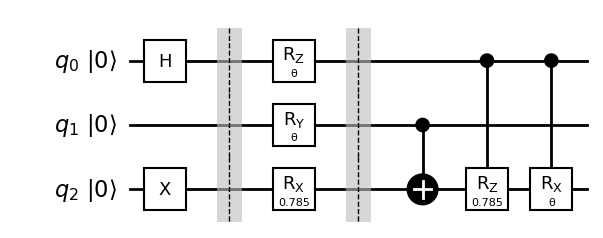

In [4]:
num_of_qubits = 3
gates=[
        [
            CircuitGate(GATES.X, target_qubit=2),
            CircuitGate(GATES.H, target_qubit=0)
        ],
        [
            CircuitGate(GATES.init_Rx(np.pi / 4), target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=0)
        ],
        [
            CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=1),
            CircuitGate(GATES.init_CRz(np.pi / 4), target_qubit=2, control_qubit=0),
            CircuitGate(GATES.CRx, target_qubit=2, control_qubit=0),
        ]
    ]
fig = get_circuit_plot(gates, num_of_qubits)
plt.show(fig)

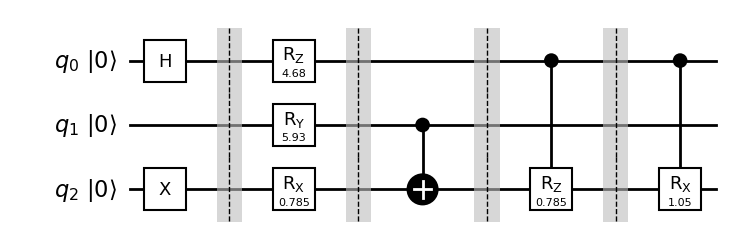

In [5]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(3),
    gates=gates,
    rng=RNG
)
fig = get_circuit_plot(circuit.base_gates, num_of_qubits)
plt.show(fig)

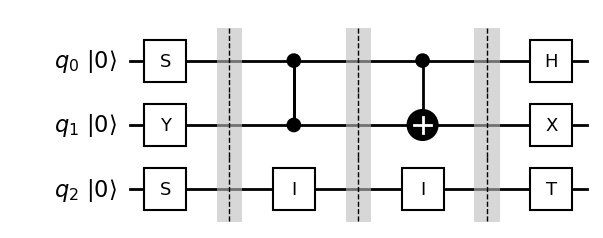

In [6]:
sampled_circuit_gates = sample_random_gates(num_of_qubits=num_of_qubits,
                                            layers=[
                                                ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
                                                # ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
                                                ("2q", 2, TWO_QUBITS_FIXED_GATE_SET),
                                                ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
                                                # ("mixed", 1, PARAMETRISED_GATE_SET),
                                            ],
                                            rng=RNG)

fig = get_circuit_plot(sampled_circuit_gates, num_of_qubits)
plt.show(fig)

In [7]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG
)

In [8]:
circuit.simulate_circuit()
print(circuit.state)

0.707i |000⟩ + 0.707i |001⟩


In [9]:
circuit.simulate_circuit_n_rounds(5)
print(circuit.state)

-0.5 |000⟩ + -0.5 |001⟩ + 0.5i |010⟩ + -0.5i |011⟩


In [10]:
print(circuit.state.measure_all(rng=RNG))

['010']


In [11]:
print(circuit.state.measure_all(num_of_measurements=15, rng=RNG))

['001' '000' '000' '011' '000' '010' '010' '000' '010' '001' '001' '001'
 '011' '011' '011']


### Fidelity

The notion of *fidelity* generalizes the idea of overlap between quantum states.  
It always lies in the interval $[0,1]$, with higher values meaning the states are closer.

---

#### 1. Pure–pure states

For two pure states $|\psi\rangle, |\phi\rangle \in \mathbb{C}^N$, the fidelity is

$$
F(|\psi\rangle, |\phi\rangle) \;=\; \big|\langle \psi \mid \phi \rangle\big|^2.
$$

- This is simply the squared inner product of the two statevectors.  
- Intuitively: it is the probability of mistaking $|\phi\rangle$ for $|\psi\rangle$ in a measurement.

---

#### 2. Pure–mixed state

For a pure state $|\psi\rangle$ and a mixed state $\rho$, the fidelity is

$$
F(|\psi\rangle, \rho) \;=\; \langle \psi \mid \rho \mid \psi \rangle.
$$

- Here, $\rho$ is a density matrix (trace-one, positive semidefinite).  
- This formula reduces to the pure–pure case if $\rho = |\phi\rangle\!\langle\phi|$.

---

#### 3. Mixed–mixed states

For two mixed states $\rho$ and $\sigma$, the (Uhlmann) fidelity is defined as

$$
F(\rho, \sigma) \;=\; \Big( \operatorname{Tr}\,\sqrt{ \sqrt{\rho}\,\sigma\,\sqrt{\rho} } \,\Big)^2.
$$

- This reduces to the previous cases when one or both arguments are pure.  
- It is the standard way of measuring closeness of two general density matrices.

---

### Intuition

Suppose $|\psi_{\text{ideal}}\rangle$ is the perfect state from a noiseless simulation,  
and $\rho_{\text{noisy}}$ is the density matrix after noise channels (SPAM, depolarizing, TDC, etc.).

Then the fidelity

$$
F(|\psi_{\text{ideal}}\rangle, \rho_{\text{noisy}})
= \langle \psi_{\text{ideal}} \mid \rho_{\text{noisy}} \mid \psi_{\text{ideal}} \rangle
$$

has a simple interpretation:

- $F = 1$ → the noisy state is **identical** to the ideal one.  
- $F = 0$ → they are **orthogonal** (completely distinguishable).  
- $0 < F < 1$ → the noisy state is partially corrupted.  

Thus fidelity quantifies the **probability of success**:  
if you prepare the noisy state but check it against the ideal basis,  
fidelity tells you the probability that the outcome looks **exactly like the ideal**.


In [12]:
print(f"|0⟩: {STATES.zero}")
print(f"|+⟩: {STATES.plus}")
print("Fidelity:", f"{fidelity(STATES.zero, STATES.plus):.5f}") 


# TODO add info what states
print(density_state)
print("Fidelity:", f"{fidelity(STATES.zero, density_state):.5f}")


|0⟩: 1 |0⟩
|+⟩: 0.707 |0⟩ + 0.707 |1⟩
Fidelity: 0.50000
0.5 |0⟩⟨0| + -0.497 |0⟩⟨1| + -0.497 |1⟩⟨0| + 0.499 |1⟩⟨1|
Fidelity: 0.49964


### Von Neumann Entropy

The **von Neumann entropy** is the quantum analogue of the Shannon entropy.  
For a quantum system described by a density matrix $\rho$, it is defined as

$$
S(\rho) = - \mathrm{Tr}\!\left(\rho \log \rho \right).
$$

If $\rho$ is diagonalized in its eigenbasis with eigenvalues $\{\eta_j\}$,

$$
S(\rho) = - \sum_j \eta_j \log \eta_j,
$$

where $0 \log 0$ is defined as 0.

---

### Pure states

A **pure state** has a density matrix of the form

$$
\rho = |\psi\rangle \langle \psi |,
$$

which has eigenvalues $[1, 0, 0, \dots]$.

Therefore the entropy is

$$
S(\rho_\text{pure}) = - \Big( 1 \cdot \log_2 1 + \sum_{j>1} 0 \cdot \log_2 0 \Big)
= 0.
$$

So pure states always have **zero entropy**.

---

### Maximally mixed states

For $n$ qubits, the maximally mixed state is

$$
\rho = \frac{I}{2^n},
$$

with eigenvalues $\tfrac{1}{2^n}$ repeated $2^n$ times.

The entropy is then

$$
S_{\max} = - \sum_{i=1}^{2^n} \frac{1}{2^n} \log_2 \frac{1}{2^n}
= \log_2 (2^n)
= n \;\text{bits}.
$$


In [13]:
# TODO

# NOISE

## (i) Depolarizing Noise

**What it is:**  
Depolarizing noise models **gate infidelities**. After the ideal gate, the affected qubit undergoes a Pauli channel that mixes in the maximally mixed state with small probability.

**When it affects:**  
- Applied **after each gate**.  
- For **1-qubit gates**: the channel acts on the operated qubit.  
- For **2-qubit gates**: the channel acts **only on the target qubit** (consistent with the asymmetric role of control vs. target in e.g. CNOT).

**Typical rates:**  
- 1-qubit gates: $p_{1}^{(1q)} \sim 10^{-3}$  
- 2-qubit gates: $p_{1}^{(2q)} \sim 5 \times 10^{-3}$  
- Often gate-dependent overrides are used (e.g. $p(\mathrm{CNOT}) \approx 0.02$).

**Mathematical representation:**  
For a density matrix $\rho$, the one-qubit depolarizing channel is
$$
\mathcal{E}_{\mathrm{depol}}(\rho)
= (1-p)\,\rho + \frac{p}{3}\Big(X\rho X + Y\rho Y + Z\rho Z\Big).
$$

- For a 1-qubit gate on qubit $q$, apply $\mathcal{E}_{\mathrm{depol}}$ to $q$.  
- For a 2-qubit gate $(c,t)$, apply $\mathcal{E}_{\mathrm{depol}}$ to the **target qubit $t$ only**.

**Kraus operators (for the affected qubit):**
$$
K_{0}=\sqrt{1-p}\,I,\qquad
K_{1}=\sqrt{\tfrac{p}{3}}\,X,\qquad
K_{2}=\sqrt{\tfrac{p}{3}}\,Y,\qquad
K_{3}=\sqrt{\tfrac{p}{3}}\,Z,
$$
so that
$$
\mathcal{E}_{\mathrm{depol}}(\rho)=\sum_{i=0}^3 K_i\,\rho\,K_i^\dagger.
$$


In [14]:
depolarizing_noise=DepolarizingNoise(
    p1_1q=0.07, 
    p1_2q=0.09,
    overrides={'H': 0.08}
)

depolarizing_noise.set_default_1q(p=0.02)
depolarizing_noise.set_default_2q(p=0.05)
depolarizing_noise.set_gate(gate="X", p=0.03)
depolarizing_noise.set_gate(gate="Z", p=0.03)


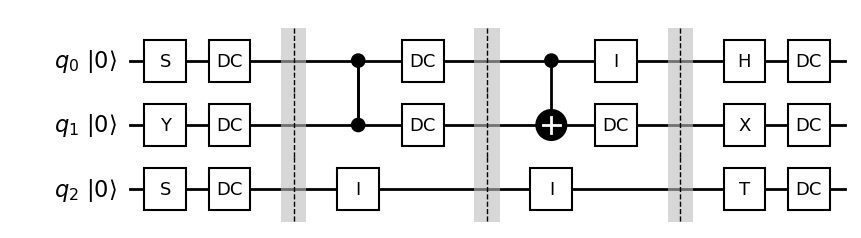

In [15]:
circuit_dc = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise()
)

fig = get_circuit_plot(sampled_circuit_gates, num_of_qubits, depolarizing_noise=True)
plt.show(fig)

In [16]:
circuit_dc.simulate_circuit()

print("Ideal state:", circuit_dc.state)          # noiseless result
print("Noisy state:", circuit_dc.noisy_dm)    # with noise applied

print(f"Ideal state probabilities:\n{circuit_dc.state.get_probabilities_str()}\n")
print(f"Noisy state probabilities:\n{circuit_dc.noisy_dm.get_probabilities_str()}\n")

print("Fidelity:", f"{fidelity(circuit_dc.state, circuit_dc.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.495 |000⟩⟨000| + 0.494 |000⟩⟨001| + 0.494 |001⟩⟨000| + 0.495 |001⟩⟨001| + 0.0043 |010⟩⟨010| + 0.00364 |010⟩⟨011| + 0.00364 |011⟩⟨010| + 0.0043 |011⟩⟨011| + 0.00066 |100⟩⟨100| + 0.00066 |100⟩⟨101| + 0.00066 |101⟩⟨100| + 0.00066 |101⟩⟨101| + 5.74e-06 |110⟩⟨110| + 4.85e-06 |110⟩⟨111| + 4.85e-06 |111⟩⟨110| + 5.74e-06 |111⟩⟨111|
Ideal state probabilities:
P(|000⟩) = 0.50000
P(|001⟩) = 0.50000

Noisy state probabilities:
P(|000⟩) = 0.49503
P(|001⟩) = 0.49503
P(|010⟩) = 0.00430
P(|011⟩) = 0.00430
P(|100⟩) = 0.00066
P(|101⟩) = 0.00066

Fidelity: 0.989


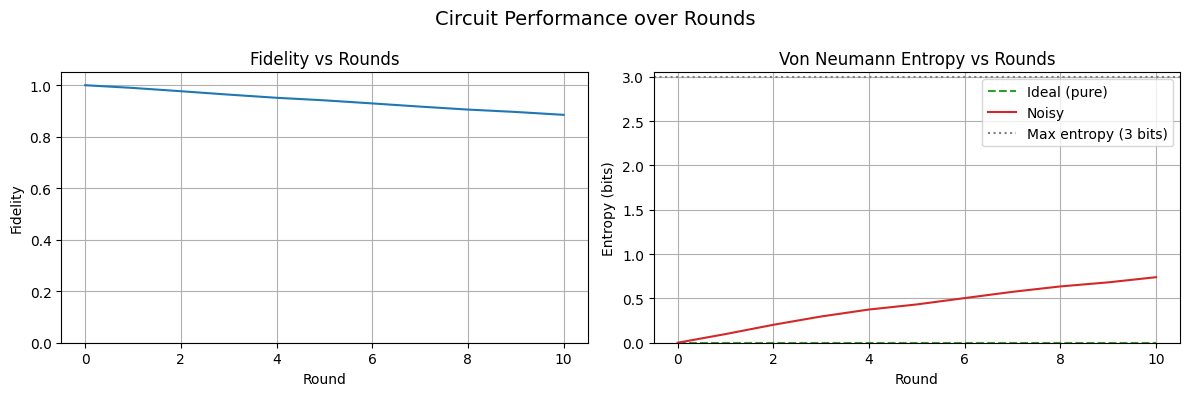

In [17]:
rounds = 10
circuit_dc.reset_circuit()
states_dc, noisy_states_dc = circuit_dc.simulate_circuit_n_rounds(rounds)

fidelities_dc = fidelities_from_arrays(states_dc, noisy_states_dc)
entropies_states_dc, entropies_noisy_dc = von_neumann_entropies_arrays(states_dc, noisy_states_dc)

plot_fidelity_and_entropy(fidelities_dc, entropies_states_dc, entropies_noisy_dc, n_rounds=rounds, num_of_qubits=num_of_qubits)

In [18]:
interactive_density_matrix_plot(states_dc, noisy_states_dc)

interactive(children=(IntSlider(value=0, description='Round', max=10), Output()), _dom_classes=('widget-intera…

## (ii) SPAM Noise

**What it is:**  
SPAM (State Preparation And Measurement) noise models **imperfect initialization** and **readout errors**.  
- **Preparation error:** when preparing $|0\rangle$, a flip to $|1\rangle$ can occur with probability $p_2$.  
- **Measurement error:** when measuring, the outcome bit can be flipped with probability $p_2$.

**When it affects:**  
- At the **start** (state preparation).  
- At the **end** (measurement).

**Typical rates:**  
- Preparation errors: $\sim 10^{-3}$.  
- Measurement errors: $\sim 1\%\text{–}5\%$ (platform-dependent).

**Mathematical representation (Pauli-$X$ channel):**  
Kraus operators
$$
K_{M0}=\sqrt{1-p_2}\,I,\qquad K_{M1}=\sqrt{p_2}\,X,
$$
so that
$$
\mathcal{E}_{\mathrm{SPAM}}(\rho)=(1-p_2)\rho+p_2\,X\rho X.
$$


In [19]:
spam_noise=SPAMNoise(
    p_prep_default=0.05, 
    p_meas_default=0.05,
    prep_overrides={1: 0.08, 2: 0.02},  # q: p
    meas_overrides={1: 0.2}
)

spam_noise.set_default_prep(p=0.02)
spam_noise.set_default_meas(p=0.02)
spam_noise.set_prep_qubit(q=2, p=0.04)
spam_noise.set_meas_qubit(q=2, p=0.04)

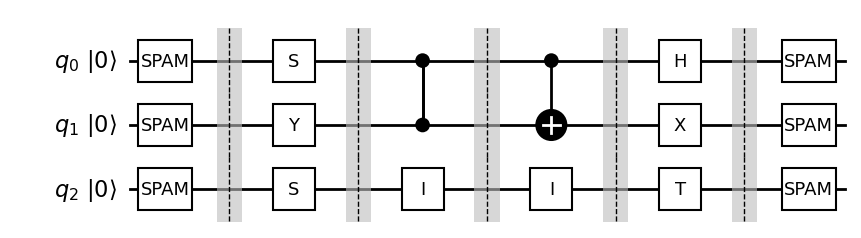

In [20]:
circuit_spam = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    spam_noise=SPAMNoise()
)

fig = get_circuit_plot(sampled_circuit_gates, num_of_qubits, spam_noise=True)
plt.show(fig)

In [21]:
circuit_spam.simulate_circuit()

print("Ideal state:", circuit_spam.state)          # noiseless result
print("Noisy state:", circuit_spam.noisy_dm)    # with noise applied

print(f"Ideal state probabilities:\n{circuit_spam.state.get_probabilities_str()}\n")
print(f"Noisy state probabilities:\n{circuit_spam.noisy_dm.get_probabilities_str()}\n")

print("Fidelity:", f"{fidelity(circuit_spam.state, circuit_spam.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.479 |000⟩⟨000| + 0.479 |000⟩⟨001| + 0.479 |001⟩⟨000| + 0.479 |001⟩⟨001| + 0.0107 |010⟩⟨010| + 0.00977 |010⟩⟨011| + 0.00977 |011⟩⟨010| + 0.0107 |011⟩⟨011| + 0.0103 |100⟩⟨100| + 0.0102 |100⟩⟨101| + 0.0102 |101⟩⟨100| + 0.0103 |101⟩⟨101| + 0.00023 |110⟩⟨110| + 0.000209 |110⟩⟨111| + 0.000209 |111⟩⟨110| + 0.00023 |111⟩⟨111|
Ideal state probabilities:
P(|000⟩) = 0.50000
P(|001⟩) = 0.50000

Noisy state probabilities:
P(|000⟩) = 0.47879
P(|001⟩) = 0.47879
P(|010⟩) = 0.01073
P(|011⟩) = 0.01073
P(|100⟩) = 0.01025
P(|101⟩) = 0.01025
P(|110⟩) = 0.00023
P(|111⟩) = 0.00023

Fidelity: 0.958


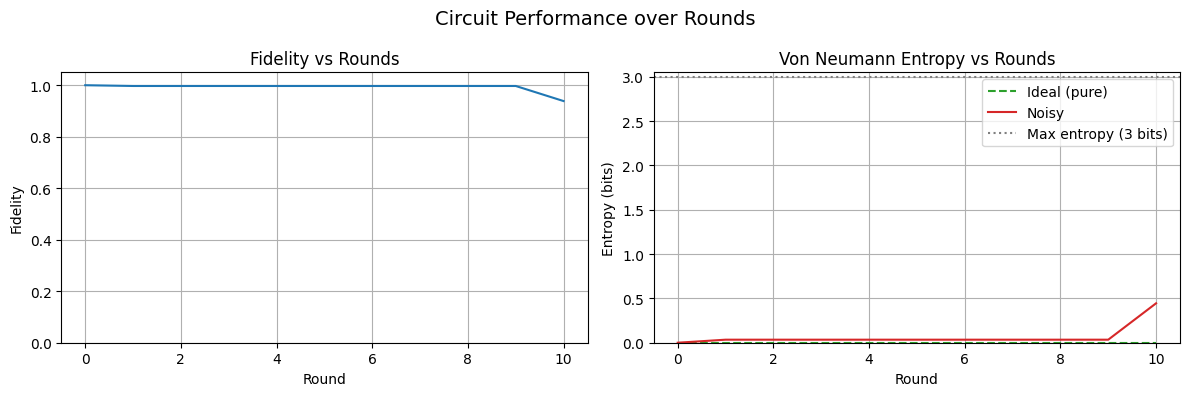

In [22]:
circuit_spam.reset_circuit()
states_spam, noisy_states_spam = circuit_spam.simulate_circuit_n_rounds(rounds)

fidelities_spam = fidelities_from_arrays(states_spam, noisy_states_spam)
entropies_states_spam, entropies_noisy_spam = von_neumann_entropies_arrays(states_spam, noisy_states_spam)

plot_fidelity_and_entropy(fidelities_spam, entropies_states_spam, entropies_noisy_spam, n_rounds=rounds, num_of_qubits=num_of_qubits)

In [23]:
interactive_density_matrix_plot(states_spam, noisy_states_spam)

interactive(children=(IntSlider(value=0, description='Round', max=10), Output()), _dom_classes=('widget-intera…

## (iii) TDC Noise (Thermal Decoherence: Relaxation + Excitation + Dephasing)

**What it models:**  
Noise per gate of duration $T_g$, acting independently on each qubit:

- **Relaxation ($T_1$):** population decay $|1\rangle \to |0\rangle$  
- **Excitation (thermal):** population rise $|0\rangle \to |1\rangle$  
- **Dephasing ($T_2$):** loss of phase coherence  

At each call, the equilibrium excited-state population is  
$$
w_e \;=\; \frac{1}{1 + e^{h f / (k_B T)}} ,
$$  
set by qubit frequency $f$ and temperature $T$.

---

**Scales & constraint:**  
- $T_1, T_2 \sim 10$–$100 \,\mu\text{s}$  
- $T_g \sim 10$–$100 \,\text{ns}$  
- Physical constraint: $T_2 \leq 2T_1$

---

### Case 1: $T_2 \leq T_1$

Per-gate probabilities:

$$
p_{T1} = e^{-T_g/T_1}, \qquad
p_{T2} = e^{-T_g/T_2},
$$

$$
p_{\text{reset}} = 1 - p_{T1}, \qquad
p_{\text{reset0}} = (1 - w_e)\, p_{\text{reset}}, \qquad
p_{\text{reset1}} = w_e\, p_{\text{reset}},
$$

$$
p_Z = (1 - p_{\text{reset}})\,\frac{1 - (p_{T2}/p_{T1})}{2}, \qquad
p_I = 1 - p_Z - p_{\text{reset0}} - p_{\text{reset1}} .
$$

Channel:

$$
\rho \;\mapsto\; \sum_{k \in \{I,Z,\text{reset0},\text{reset1}\}} K_k \, \rho \, K_k^\dagger .
$$

Kraus operators:

$$
K_I = \sqrt{p_I}\, I, \quad
K_Z = \sqrt{p_Z}\, Z, \quad
K_{\text{reset0}} = \sqrt{p_{\text{reset0}}}\,|0\rangle \langle 0|, \quad
K_{\text{reset1}} = \sqrt{p_{\text{reset1}}}\,|1\rangle \langle 1| .
$$

---

### Case 2: $T_1 < T_2 \leq 2T_1$

Here the direct mixture above does not yield a valid CP map.  
Instead we construct the **Choi matrix** by evaluating the channel on the basis operators:

- $\mathcal{E}(|0\rangle \langle 0|) = (1-p_{\text{reset1}})|0\rangle \langle 0| + p_{\text{reset1}}|1\rangle \langle 1|$  
- $\mathcal{E}(|1\rangle \langle 1|) = p_{\text{reset0}}|0\rangle \langle 0| + (1-p_{\text{reset0}})|1\rangle \langle 1|$  
- $\mathcal{E}(|0\rangle \langle 1|) = p_{T2}\, |0\rangle \langle 1|$  
- $\mathcal{E}(|1\rangle \langle 0|) = p_{T2}\, |1\rangle \langle 0|$

Assembled into the $4 \times 4$ Choi matrix:

$$
C =
\begin{pmatrix}
1 - p_{\text{reset1}} & 0 & 0 & p_{T2} \\
0 & p_{\text{reset1}} & 0 & 0 \\
0 & 0 & p_{\text{reset0}} & 0 \\
p_{T2} & 0 & 0 & 1 - p_{\text{reset0}}
\end{pmatrix}.
$$

The channel action is then

$$
\rho \;\mapsto\; \text{Tr}_1 \!\left[ C \, (\rho^T \otimes I) \right] .
$$

**Implementation:** obtain Kraus operators by performing an SVD (or eigendecomposition if $C$ is Hermitian), then reshaping the singular/eigenvectors into $2\times 2$ matrices. This ensures a valid CPTP map.

---

### Note on Practical Use

- At **dilution-fridge temperatures** ($\sim 10$–$20$ mK, GHz qubits), $w_e \ll 1\%$, so excitation can often be ignored (reducing to TRC).  
- At **higher temperatures** or in systems with non-negligible excited-state population (e.g. photonic simulators, solid-state spins at room $T$), including $p_{\text{reset1}}$ is important.  
- This generalized form is called the **thermal decoherence (TDC)** channel.


In [24]:
tdc_noise=TDCNoise(
    T1_default=0.000002, 
    T2_default=0.000003,
    f_default=3.0e5,
    temp_default=0.1,  # mK
    
    T1_overrides={0: 0.002, 3: 0.2},  # q: p
    T2_overrides={1: 0.003},
    
    freq_overrides={0: 4.0e5, 3: 4.0e5},  # q: f
    temp_overrides={1: 0.2},  # q: t
)

tdc_noise.set_T1(q=0, T1=0.00003)
tdc_noise.set_T2(q=2, T2=0.003)
tdc_noise.set_gate_duration(gate="H", seconds=0.003)
tdc_noise.set_frequency(q=2, f_hz=4.0e7)
tdc_noise.set_temperature(q=0, T_K=0.3)

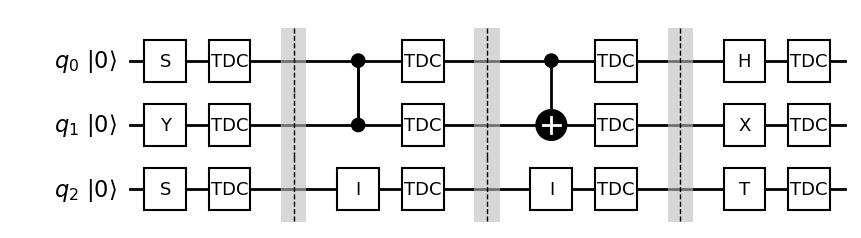

In [25]:
circuit_tdc = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    tdc_noise=TDCNoise()
)

fig = get_circuit_plot(sampled_circuit_gates, num_of_qubits, tdc_noise=True)
plt.show(fig)


In [26]:
circuit_tdc.simulate_circuit()

print("Ideal state:", circuit_tdc.state)          # noiseless result
print("Noisy state:", circuit_tdc.noisy_dm)    # with noise applied

print(f"Ideal state probabilities:\n{circuit_tdc.state.get_probabilities_str()}\n")
print(f"Noisy state probabilities:\n{circuit_tdc.noisy_dm.get_probabilities_str()}\n")

print("Fidelity:", f"{fidelity(circuit_tdc.state, circuit_tdc.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.5 |000⟩⟨000| + 0.5 |000⟩⟨001| + 0.5 |001⟩⟨000| + 0.5 |001⟩⟨001|
Ideal state probabilities:
P(|000⟩) = 0.50000
P(|001⟩) = 0.50000

Noisy state probabilities:
P(|000⟩) = 0.50017
P(|001⟩) = 0.49983

Fidelity: 1.000


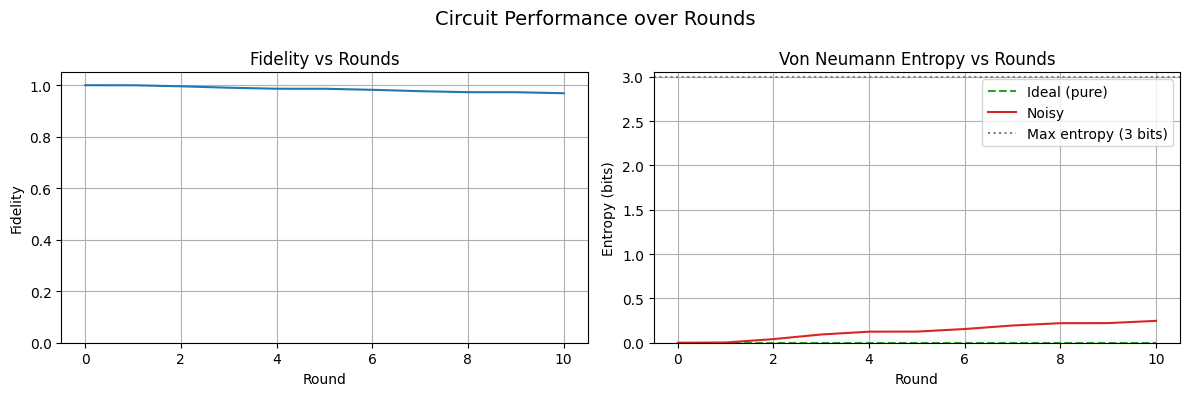

In [27]:
circuit_tdc.reset_circuit()
states_tdc, noisy_states_tdc = circuit_tdc.simulate_circuit_n_rounds(rounds)

fidelities_tdc = fidelities_from_arrays(states_tdc, noisy_states_tdc)
entropies_states_tdc, entropies_noisy_tdc = von_neumann_entropies_arrays(states_tdc, noisy_states_tdc)

plot_fidelity_and_entropy(fidelities_tdc, entropies_states_tdc, entropies_noisy_tdc, n_rounds=rounds, num_of_qubits=num_of_qubits)

In [28]:
interactive_density_matrix_plot(states_tdc, noisy_states_tdc)

interactive(children=(IntSlider(value=0, description='Round', max=10), Output()), _dom_classes=('widget-intera…

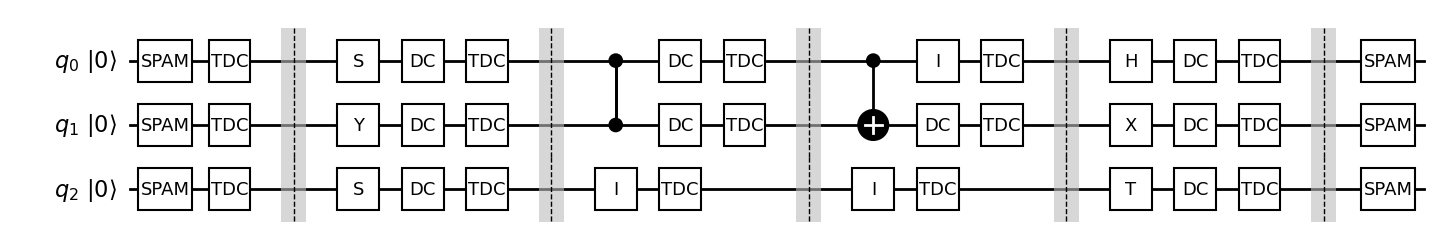

In [29]:
circuit_noisy = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise(),
    spam_noise=SPAMNoise(),
    tdc_noise=TDCNoise()
)

fig = get_circuit_plot(sampled_circuit_gates, num_of_qubits, True, True, True)
plt.show(fig)


In [30]:
circuit_noisy.simulate_circuit()

print("Ideal state:", circuit_noisy.state)          # noiseless result
print("Noisy state:", circuit_noisy.noisy_dm)    # with noise applied
print("Fidelity:", f"{fidelity(circuit_noisy.state, circuit_noisy.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.474 |000⟩⟨000| + 0.473 |000⟩⟨001| + 0.473 |001⟩⟨000| + 0.474 |001⟩⟨001| + 0.0148 |010⟩⟨010| + 0.0132 |010⟩⟨011| + 0.0132 |011⟩⟨010| + 0.0148 |011⟩⟨011| + 0.0108 |100⟩⟨100| + 0.0108 |100⟩⟨101| + 0.0108 |101⟩⟨100| + 0.0108 |101⟩⟨101| + 0.000336 |110⟩⟨110| + 0.0003 |110⟩⟨111| + 0.0003 |111⟩⟨110| + 0.000336 |111⟩⟨111|
Fidelity: 0.947


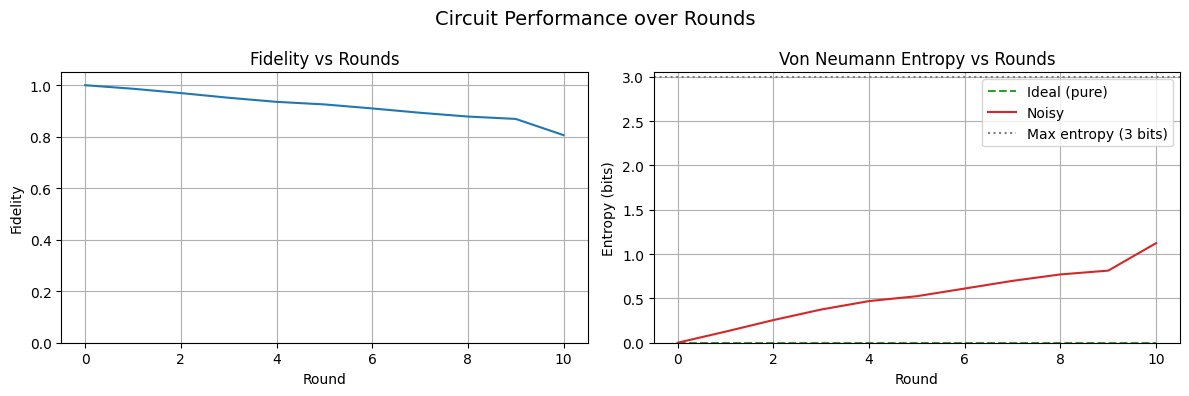

In [31]:
circuit_noisy.reset_circuit()
states_noisy, noisy_states_noisy = circuit_noisy.simulate_circuit_n_rounds(rounds)

fidelities_noisy = fidelities_from_arrays(states_noisy, noisy_states_noisy)
entropies_states_noisy, entropies_noisy_noisy = von_neumann_entropies_arrays(states_noisy, noisy_states_noisy)
plot_fidelity_and_entropy(fidelities_noisy, entropies_states_noisy, entropies_noisy_noisy, n_rounds=rounds, num_of_qubits=num_of_qubits)

In [32]:
interactive_density_matrix_plot(states_noisy, noisy_states_noisy)

interactive(children=(IntSlider(value=0, description='Round', max=10), Output()), _dom_classes=('widget-intera…

### Comparision o noise channels

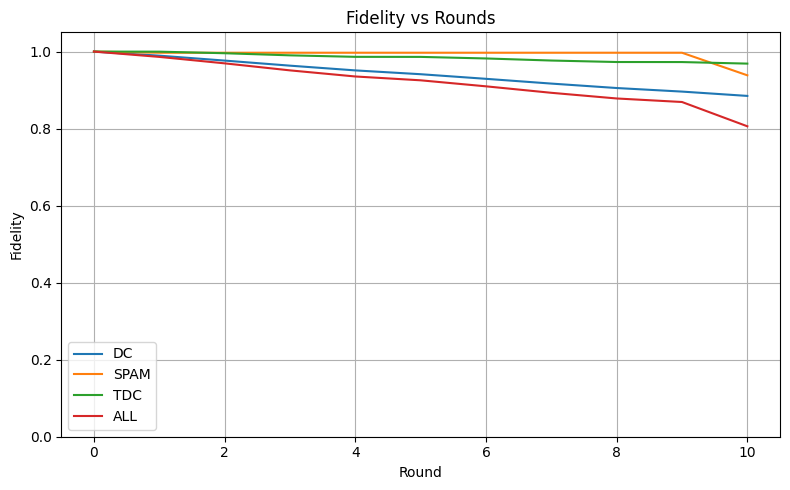

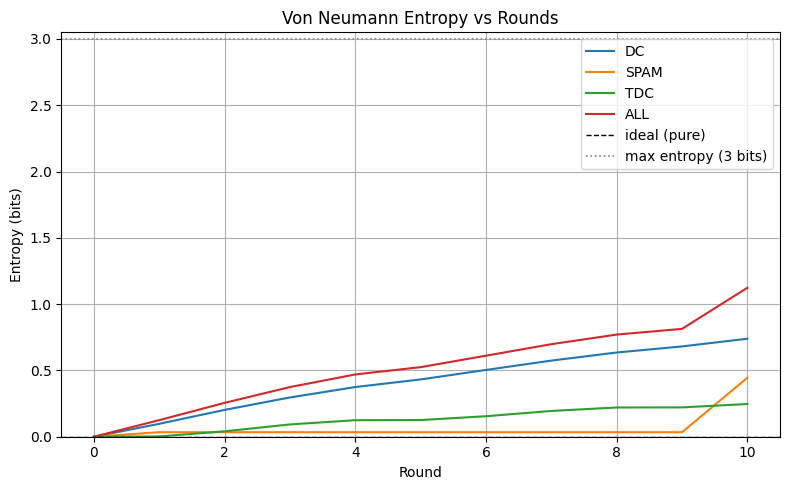

In [33]:
fidelities_by_noise = {
    "DC": fidelities_dc,
    "SPAM": fidelities_spam,
    "TDC": fidelities_tdc,
    "ALL": fidelities_noisy,
}
entropies_noisy_by_noise = {
    "DC": entropies_noisy_dc,
    "SPAM": entropies_noisy_spam,
    "TDC": entropies_noisy_tdc,
    "ALL": entropies_noisy_noisy,
}

plot_fidelities_by_noise(fidelities_by_noise, n_rounds=rounds)
plot_entropies_by_noise(entropies_noisy_by_noise, n_rounds=rounds, num_of_qubits=num_of_qubits)

## Expressibility

**What it measures:**  
How well a parameterized quantum circuit (PQC) explores Hilbert space.

**How it is computed (paper):**  
1. Generate many random parameterizations of the same circuit ansatz.  
2. For each, compute the output quantum state.  
3. Compute pairwise fidelities between states.  
4. Compare the resulting fidelity distribution with the Haar-random distribution.  
5. The difference (e.g. KL divergence) quantifies *expressibility*.  

**Intuition:**  
- High expressibility → circuit can approximate Haar-random states.  
- Low expressibility → circuit explores only a small subspace.


## Entangling Capability

**What it measures:**  
How much entanglement the circuit can generate on average.

**How it is computed (paper):**  
1. Generate many random parameterizations of the same circuit ansatz.  
2. For each, compute the output state.  
3. Calculate bipartite entanglement entropy (von Neumann entropy of reduced density matrices).  
4. Average this entropy across samples.  

**Intuition:**  
- High entangling capability → circuit tends to create strongly entangled states.  
- Low entangling capability → circuit output remains weakly entangled or separable.


# Random circuit sampling

## One qubit

In [37]:
num_of_qubits = 1
samples = 2000
dim = 2 ** num_of_qubits  # Hilbert space dimension
num_of_circuits = 4

# Arrays to store pure vectors and noisy density matrices
states = np.zeros((num_of_circuits, samples, dim, 1), dtype=complex)       # statevectors (ideal)
noisy_states = np.zeros((num_of_circuits, samples, dim, dim), dtype=complex)  # density matrices

circuits_gates_list = [
    [[CircuitGate(GATES.I, target_qubit=0)]],
    [[CircuitGate(GATES.H, target_qubit=0), CircuitGate(GATES.Rz, target_qubit=0)]],
    [[CircuitGate(GATES.H, target_qubit=0), CircuitGate(GATES.Rz, target_qubit=0), CircuitGate(GATES.Rx, target_qubit=0)]],
    [[CircuitGate(GATES.Rx, target_qubit=0), CircuitGate(GATES.Rz, target_qubit=0), CircuitGate(GATES.Ry, target_qubit=0)]]
]

for circ_idx, circuit_gates_list in enumerate(circuits_gates_list):
    circuit = Circuit(
        state=STATES.generate_zero_n_qubit_state(1),
        gates=circuit_gates_list,
        rng=RNG,
        depolarizing_noise=DepolarizingNoise(),
        spam_noise=SPAMNoise(),
        tdc_noise=TDCNoise()
    )
    
    for i in range(samples):
        circuit.simulate_circuit()
        
        states[circ_idx, i, :, :] = circuit.state.qubit_vector
        noisy_states[circ_idx, i, :, :] = circuit.noisy_dm.rho
        
        circuit.reset_circuit()
    
    


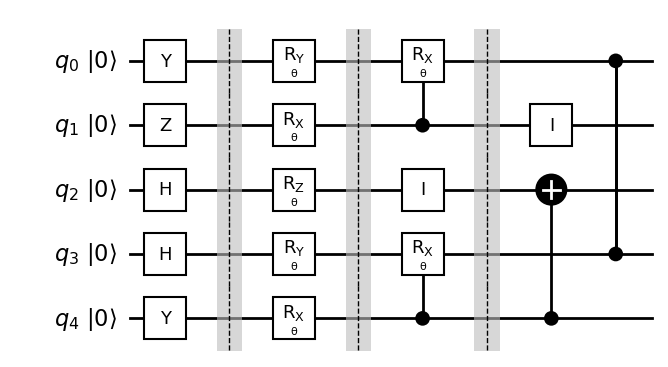

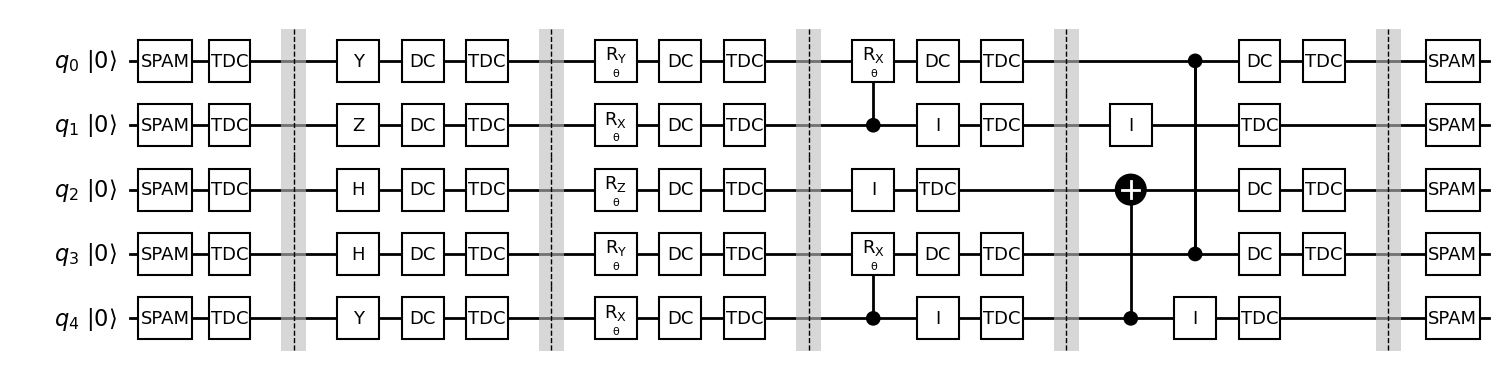

In [34]:
# circuit 1
num_of_qubits1 = 5

sampled_circuit_gates_parametrized_1 = sample_random_gates(
    num_of_qubits=num_of_qubits1,
    layers=[
        ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
        ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
        ("2q", 1, TWO_QUBITS_PARAMETRISED_GATE_SET),
        ("2q", 1, TWO_QUBITS_FIXED_GATE_SET),
        # ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
        # ("mixed", 1, PARAMETRISED_GATE_SET),
    ],
    rng=RNG
)

fig = get_circuit_plot(sampled_circuit_gates_parametrized_1, num_of_qubits1)
plt.show(fig)

fig = get_circuit_plot(sampled_circuit_gates_parametrized_1, num_of_qubits1, True, True, True)
plt.show(fig)

In [35]:
circuit_1 = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits1),
    gates=sampled_circuit_gates_parametrized_1,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise(),
    spam_noise=SPAMNoise(),
    tdc_noise=TDCNoise()
)


In [36]:
n = 10
dim = 2 ** circuit_1.state.num_of_qubits  # Hilbert space dimension

# Arrays to store pure vectors and noisy density matrices
states = np.zeros((n, dim, 1), dtype=complex)       # statevectors (ideal)
noisy_states = np.zeros((n, dim, dim), dtype=complex)  # density matrices

for i in range(n):
    circuit_1.simulate_circuit()

    # print("Ideal state:", circuit_1.state)        # noiseless statevector
    # print("Noisy state:", circuit_1.noisy_dm)     # density matrix with noise

    # Save
    states[i, :, :] = circuit_1.state.qubit_vector
    noisy_states[i, :, :] = circuit_1.noisy_dm.rho
    
    print("Fidelity:", f"{fidelity(circuit_1.state, circuit_1.noisy_dm):.3f}")  # overlap ∈ [0,1]
    circuit_1.reset_circuit()

Fidelity: 0.903
Fidelity: 0.879
Fidelity: 0.882
Fidelity: 0.886
Fidelity: 0.875
Fidelity: 0.900
Fidelity: 0.904
Fidelity: 0.885
Fidelity: 0.896
Fidelity: 0.886
